# Importação de Bibliotecas

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler
import plotly.express as px
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Input
import numpy as np
import plotly.graph_objects as go
from sklearn.metrics import classification_report
import plotly.figure_factory as ff
from sklearn.metrics import confusion_matrix

# Conectando com o Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importando a Base de Dados

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Ponderadas/train_transaction.csv')
df.head(3)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 394 entries, TransactionID to V339
dtypes: float64(376), int64(4), object(14)
memory usage: 1.7+ GB


In [5]:
df.columns

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5',
       ...
       'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338',
       'V339'],
      dtype='object', length=394)

In [6]:
df['V1']

,V1
0,1.0
1,NaN
2,1.0
3,NaN
4,NaN
...,...
590535,1.0
590536,1.0
590537,1.0
590538,1.0


Os dados do IEEE possuem colunas sobre fraude em cartões de crédito com valores nulos.

São colunas que estavam na base de fraudes da ponderada da semana 4. Substituirei os nulos por uma junção dessas bases para que não tenha-se valores NaN em certas colunas.

In [7]:
df_fraude = pd.read_csv('/content/drive/MyDrive/Ponderadas/creditcard.csv')
df_fraude.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [8]:
colunas_fraude = [col for col in df_fraude.columns if col.startswith('V') and col[1:].isdigit()]

df = pd.concat([df, df_fraude[colunas_fraude]], axis=1)
df.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153


# Análise sobre a Base de Dados

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 422 entries, TransactionID to V28
dtypes: float64(404), int64(4), object(14)
memory usage: 1.9+ GB




*   Número de colunas: 422 -> Representa também o número de features.
*   Número de linhas: 590540 -> Ou seja, trata-se da quantidade total de registros dos dados.


## Tipos de Dados

In [10]:
df.dtypes

,0
TransactionID,int64
isFraud,int64
TransactionDT,int64
TransactionAmt,float64
ProductCD,object
...,...
V24,float64
V25,float64
V26,float64
V27,float64


# Descrição Estatística
- Média
- Desvio Padrão
- Valores Mínimo
- Valores Máximo

In [11]:
df.describe()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,...,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
count,5.905400e+05,590540.000000,5.905400e+05,590540.000000,590540.000000,581607.000000,588975.000000,586281.000000,524834.000000,524834.000000,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05
mean,3.282270e+06,0.034990,7.372311e+06,135.027176,9898.734658,362.555488,153.194925,199.278897,290.733794,86.800630,...,1.039842e-15,6.406703e-16,1.654566e-16,-3.572585e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683431e-15,-3.660153e-16,-1.227577e-16
std,1.704744e+05,0.183755,4.617224e+06,239.162522,4901.170153,157.793246,11.336444,41.244453,101.741072,2.690623,...,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01
min,2.987000e+06,0.000000,8.640000e+04,0.251000,1000.000000,100.000000,100.000000,100.000000,100.000000,10.000000,...,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01
25%,3.134635e+06,0.000000,3.027058e+06,43.321000,6019.000000,214.000000,150.000000,166.000000,204.000000,87.000000,...,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02
50%,3.282270e+06,0.000000,7.306528e+06,68.769000,9678.000000,361.000000,150.000000,226.000000,299.000000,87.000000,...,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02
75%,3.429904e+06,0.000000,1.124662e+07,125.000000,14184.000000,512.000000,150.000000,226.000000,330.000000,87.000000,...,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02
max,3.577539e+06,1.000000,1.581113e+07,31937.391000,18396.000000,600.000000,231.000000,237.000000,540.000000,102.000000,...,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01


# Verificando Valores Ausentes

In [12]:
df.isnull().sum()

,0
TransactionID,0
isFraud,0
TransactionDT,0
TransactionAmt,0
ProductCD,0
...,...
V24,305733
V25,305733
V26,305733
V27,305733


# Verificando os Valores Únicos por Coluna

In [13]:
df.nunique()

,0
TransactionID,590540
isFraud,2
TransactionDT,573349
TransactionAmt,20902
ProductCD,5
...,...
V24,275663
V25,275663
V26,275663
V27,275663


# Etapas do Pré-Processamento
- Tratamento de dados nulos
- Normalização
- One Hoting Encoding

# Tratamento de Dados Nulos
- Decisão de manter ou excluir colunas com muitos valores bulos:
Se uma coluna contém uma alta proporção de valores nulos (ex. > 60%), talvez seja necessário removê-la, pois pode não fornecer informação útil ao modelo.

In [14]:
threshold = 0.6
df = df.dropna(thresh=int((1-threshold)*len(df)), axis=1)

Preenchimento de Valores Nulos
Variáveis Numéricas:
média/mediana podem ser apropriadoa para essas colunas em si.

In [15]:
colunasnumericas = df.select_dtypes(include=['float', 'int']).columns

# Preencha os NaN das colunas numéricas com a média
for column in colunasnumericas:
    mean_value = df[column].mean()
    df[column].replace(0.0, mean_value, inplace=True)
    df[column].fillna(mean_value, inplace=True)

df.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
0,2987000,0.03499,86400,68.5,W,13926,362.555488,150.0,discover,142.0,...,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053
1,2987001,0.03499,86401,29.0,W,2755,404.000000,150.0,mastercard,102.0,...,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724
2,2987002,0.03499,86469,59.0,W,4663,490.000000,150.0,visa,166.0,...,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752
3,2987003,0.03499,86499,50.0,W,18132,567.000000,150.0,mastercard,117.0,...,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458
4,2987004,0.03499,86506,50.0,H,4497,514.000000,150.0,mastercard,102.0,...,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153


# Normalização dos Dados
A normalização de colunas numéricas é uma etapa essencial no pré-processamento dos dados, especialmente em modelos de Machine Learning. Ela ajuda a padronizar a escala das variáveis numéricas, garantindo que nenhuma variável domine as outras devido à sua magnitude.

In [16]:
colunasnumericas = df.select_dtypes(include=['float64', 'int64']).columns

scaler = MinMaxScaler()
df[colunasnumericas] = scaler.fit_transform(df[colunasnumericas])

Verificando:

In [17]:
df.describe()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,...,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
count,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,...,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000
mean,0.500000,0.034990,0.463341,0.004220,0.511539,0.525111,0.406068,0.724663,0.433486,0.834789,...,0.563315,0.580265,0.561480,0.510031,0.665434,0.382234,0.577907,0.425448,0.416511,0.313124
std,0.288676,0.183755,0.293628,0.007489,0.281741,0.313190,0.086423,0.299967,0.217987,0.027571,...,0.063570,0.008208,0.011841,0.033854,0.009274,0.081611,0.029261,0.078771,0.007450,0.006698
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.250000,0.000000,0.187008,0.001349,0.288515,0.230000,0.381679,0.481752,0.238636,0.836957,...,0.527682,0.578011,0.557798,0.484730,0.663030,0.334454,0.560104,0.372036,0.415203,0.312049
50%,0.500000,0.000000,0.459157,0.002145,0.498850,0.522000,0.381679,0.919708,0.433486,0.836957,...,0.563606,0.579600,0.561005,0.510347,0.665267,0.387756,0.578838,0.416932,0.416536,0.313352
75%,0.750000,0.000000,0.709724,0.003906,0.757875,0.824000,0.381679,0.919708,0.515909,0.836957,...,0.599155,0.581682,0.564484,0.534688,0.667626,0.441460,0.597593,0.464807,0.418191,0.314712
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Aplicando a etapa de One Hot Encoding
O One-Hot Encoding é uma técnica usada para converter colunas categóricas em uma representação binária, de forma que cada categoria se torne uma nova coluna com valores 0 ou 1. Isso é especialmente útil para colunas não numéricas em modelos de Machine Learning.

In [18]:
colunas_categoricas = df.select_dtypes(include=['object', 'category']).columns

In [19]:
df_encoded = pd.get_dummies(df, columns=colunas_categoricas, drop_first=True)

In [20]:
df_geral = df_encoded

# Criação do Modelo

A escolha do Modelo em si, foi o de arqutetura LSTM:
- Trabalha-se com dados sequenciais e séries temporais;
- Tem uma alta capacidade de capturar dependências ao longp do tempo.

## Selecionado 10% de Amostra do df

In [21]:
df_amostras = df_geral.sample(frac=0.1, random_state=42)

In [22]:
timesteps = 1
num_features = df_amostras.shape[1] - 1

In [23]:
# Preparar os dados
X = df_amostras.drop(columns=['isFraud']).values
y = df_amostras['isFraud'].values

In [24]:
# Redimensionar para o formato
X = X.reshape((X.shape[0], timesteps, num_features))

## Aplicando o balanceamento SMOTE

In [26]:
# Impute missing values using SimpleImputer
!pip install sklearn
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean') # You can choose a different strategy like 'median' or 'most_frequent'

# Reshape X back to its original shape
X = X.reshape(X.shape[0], -1)

# Impute missing values in X
X = imputer.fit_transform(X)

# Reshape X back to the required shape for SMOTE
X = X.reshape((X.shape[0], timesteps, num_features))

# Balanceamento com SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X.reshape(X.shape[0], -1), y)  # reshape para aplicar SMOTE
X_resampled = X_resampled.reshape((X_resampled.shape[0], timesteps, num_features))

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [27]:
# Divisão entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

In [28]:
model = Sequential()
model.add(Input(shape=(timesteps, num_features)))
model.add(LSTM(128, activation='tanh', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, activation='tanh', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [29]:
history = model.fit(X_train, y_train, epochs=30, batch_size=64, validation_data=(X_test, y_test))

y_pred_prob = model.predict(X_test)
threshold = 0.3
y_pred = (y_pred_prob >= threshold).astype(int)

Epoch 1/30
1246/1246 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.7283 - loss: 0.5376 - val_accuracy: 0.7758 - val_loss: 0.4594
Epoch 2/30
1246/1246 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.7815 - loss: 0.4526 - val_accuracy: 0.8047 - val_loss: 0.4261
Epoch 3/30
1246/1246 ━━━━━━━━━━━━━━━━━━━━ 23s 12ms/step - accuracy: 0.8065 - loss: 0.4160 - val_accuracy: 0.8211 - val_loss: 0.3938
Epoch 4/30
1246/1246 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - accuracy: 0.8268 - loss: 0.3809 - val_accuracy: 0.8374 - val_loss: 0.3587
Epoch 5/30
1246/1246 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.8481 - loss: 0.3430 - val_accuracy: 0.8558 - val_loss: 0.3280
Epoch 6/30
1246/1246 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.8631 - loss: 0.3146 - val_accuracy: 0.8858 - val_loss: 0.2764
Epoch 7/30
1246/1246 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.8776 - loss: 0.2841 - val_accuracy: 0.8931 - val_loss: 0.2597
Epoch 8/30
1246/1246 ━━━━━━━━━━━━━━━━━━━━ 23s 12ms/step - accuracy: 0.8874 -

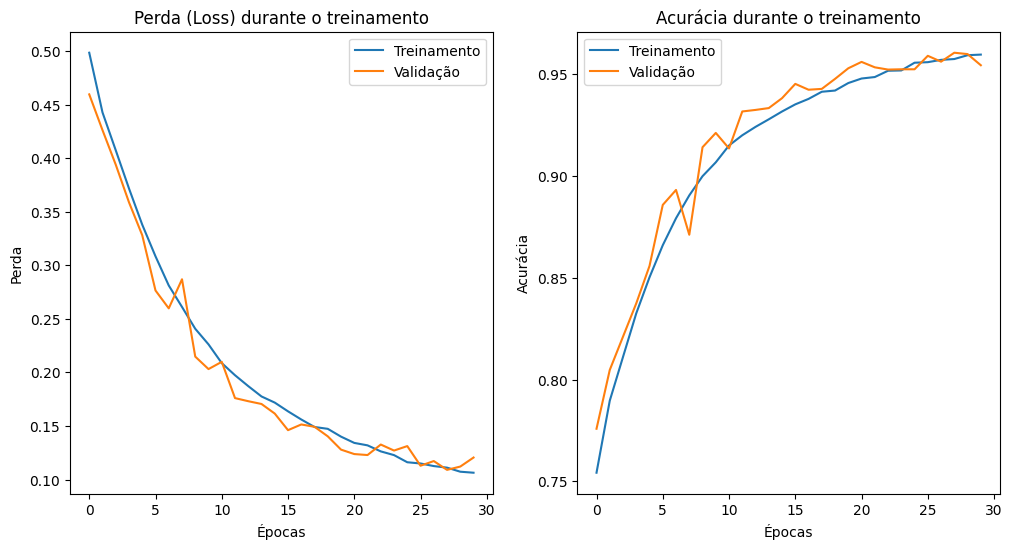

In [30]:
# Plotando a perda (loss)
plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Treinamento')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Perda (Loss) durante o treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

# Acurácia plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Treinamento')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Acurácia durante o treinamento')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()

plt.show()

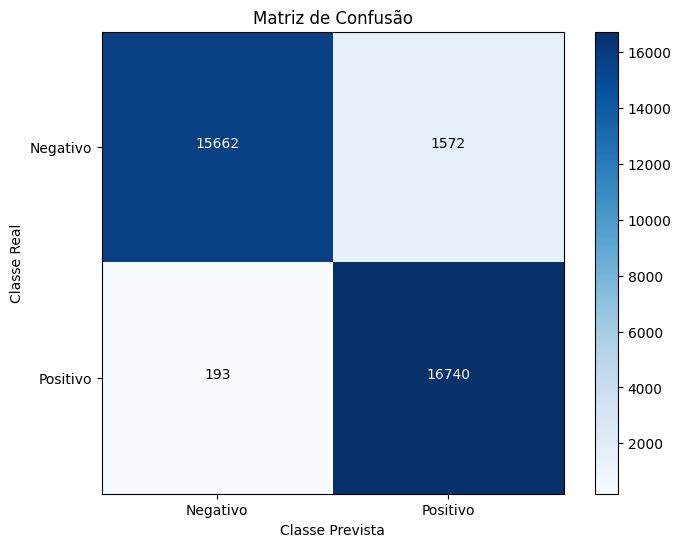

In [31]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusão')
plt.colorbar()
tick_marks = [0, 1]  # Para classificação binária
plt.xticks(tick_marks, ['Negativo', 'Positivo'])
plt.yticks(tick_marks, ['Negativo', 'Positivo'])

# Anotando os valores na matriz
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > cm.max() / 2. else 'black')

plt.ylabel('Classe Real')
plt.xlabel('Classe Prevista')
plt.show()

In [32]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.99      0.91      0.95     17234
         1.0       0.91      0.99      0.95     16933

    accuracy                           0.95     34167
   macro avg       0.95      0.95      0.95     34167
weighted avg       0.95      0.95      0.95     34167

